# Input for emu_v1

In this notebook, we explain how to get the input for the P3D emulator v1. This algorithm emulates the best-fitting Arinyo parameters to P1D+P3D measurements. Specifically, it finds the best-fitting Arinyo parameters by considering P3D measurements in the loss

<b>P3D in the loss</b>

In [1]:
# %load first_cell.py
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=67.26, Om0=0.314, Ob0=0.049)

from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"


def print_shape(*args):
    nelem = len(args)
    for ii in range(nelem - 1):
        print(args[ii].shape, end=" ")
    print(args[nelem - 1].shape)


def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder


path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


/home/jchaves/Proyectos/projects/lya/lya_pk/


#### Read the target P3D from LaCE and P3D errors

To get CAMB interpolators, run following cells (data_for_emu_v1) for all options

In [2]:
from lace.archive import pnd_archive
from lya_pk.input_emu import data_for_emu_v1, params_numpy2dict, get_flag_out

In [38]:
sim_suite = "hypercube"
# option_list = [
#     "growth",
#     "neutrinos",
#     "central",
#     "seed",
#     "curved",
#     "reionization",
#     "running",
# ]
# sim_suite = option_list[6]

if sim_suite == "hypercube":
    archive = pnd_archive.archivePND(nsamples=30)
else:
    archive = pnd_archive.archivePND(pick_sim=sim_suite)
archive.average_over_samples(flag="all")

In [39]:
archive.data[0]["ind_sim"]

0

In [40]:
folder = path_program + "data/"
if path_program == "/home/jchaves/Proyectos/projects/lya/lya_pk/":
    folder_chains = (
        "/home/jchaves/Proyectos/projects/lya/data/pkfits/p3d_fits_new/"
    )
else:
    folder_chains = "/data/desi/scratch/jchavesm/p3d_fits_new/"

folder_interp = path_program + "data/plin_interp/"
folder_lya_data = path_program + "data/best_arinyo/"

if sim_suite == "hypercube":
    err_p1d = np.load(folder + "p1d_4_fit.npz")
    err_p3d = np.load(folder + "p3d_4_fit.npz")
else:
    err_p1d = np.load(folder + "p1d_4_fit_extended.npz")
    err_p3d = np.load(folder + "p3d_4_fit_extended.npz")

kmax_3d = 5
noise_3d = 0.075
kmax_1d = 5
noise_1d = 0.01

In [41]:
# arch = []
# for ii in range(2):
#     arch.append(archive.data_av_all[ii])

In [42]:
%%time
data_emu = data_for_emu_v1(
    folder_chains,
    folder_interp,
    archive.data_av_all,
    err_p3d,
    err_p1d,
    kmax_3d,
    noise_3d,
    kmax_1d,
    noise_1d,
    sim_suite,
)

CPU times: user 10.9 s, sys: 2.58 s, total: 13.5 s
Wall time: 13.5 s


In [ ]:
data_emu.keys()

- 'in_params': cosmo + IGM params (those with emu_params_names)
- 'out_params': Arinyo best-fitting params
- 'model': model to compute loss, in contains all relevant information

#### Predict P3D

For first simulation

In [43]:
ind_book = 0
pars = params_numpy2dict(data_emu["out_params"][ind_book])
p3d = data_emu["model"][ind_book].get_model_3d(pars)

### Predict linear power spectrum

In [15]:
z = data_emu["model"][ind_book].data["z"][0]
k_Mpc =data_emu["model"][ind_book].data["k3d"]
linP = data_emu["model"][ind_book].model.linP_Mpc(z=z, k_Mpc=k_Mpc)
linP_nodim = (linP * data_emu["model"][ind_book].data["k3d"] ** 3
            / 2
            / np.pi**2
        )

In [16]:
(p3d/linP_nodim)[:,0]

array([0.48468206, 0.4947535 , 0.5109359 , 0.52825589, 0.54020549,
       0.56426973, 0.59292631, 0.62297485, 0.65794375, 0.70352777,
       0.74566812, 0.79667244, 0.8525852 , 0.90543742, 0.94783585,
       0.96567954, 0.9337906 , 0.8206873 , 0.60719624, 0.33081525])

#### Compare best-fitting prediction with data

<IPython.core.display.Javascript object>


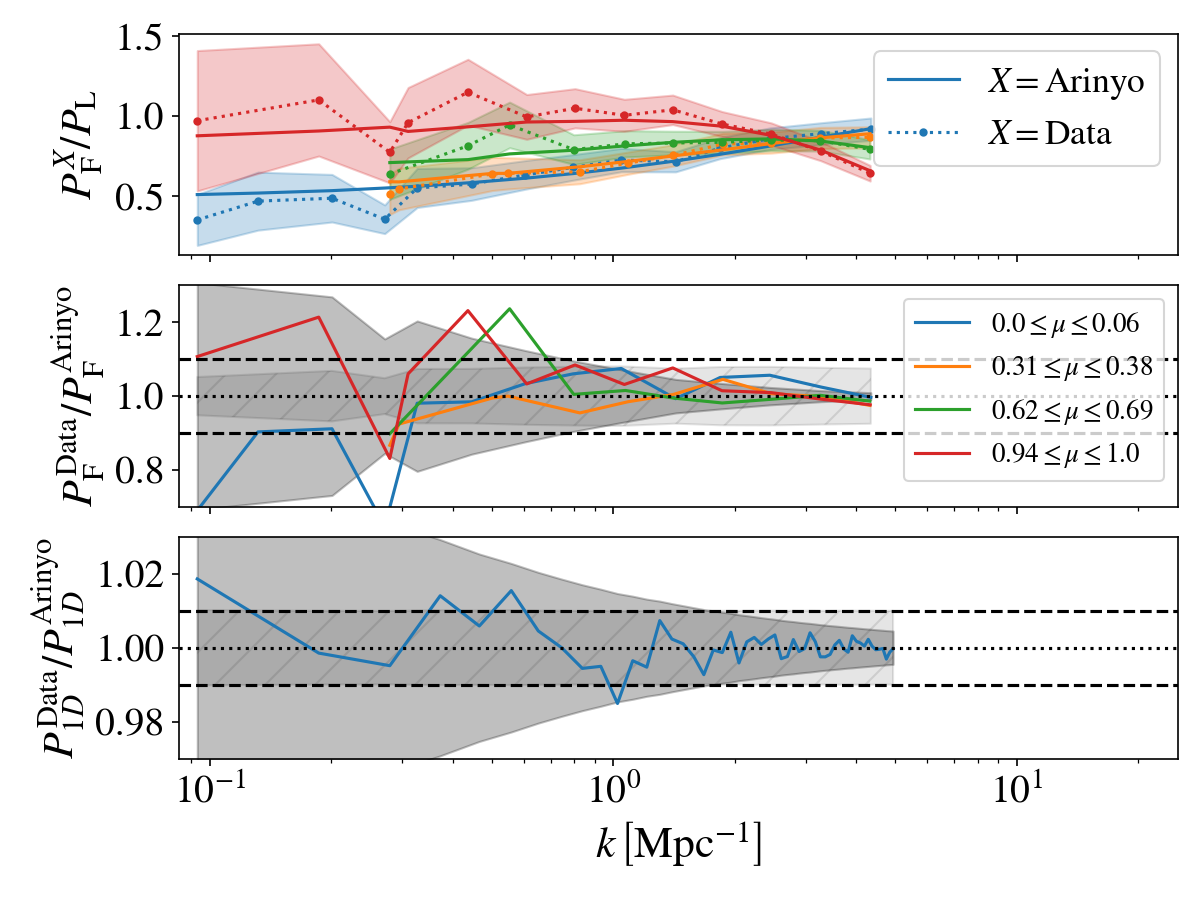

In [44]:
ind_book = 0
pars = params_numpy2dict(data_emu["out_params"][ind_book])
data_emu["model"][ind_book].plot_fits(pars)

## Put together simple loss in numpy

Input data for loss

In [ ]:
ind_book = 0

# identify (k,mu) for bins included in fit
data_dict_loss = {}

model = data_emu["model"][ind_book]
# to compute theory
data_dict_loss["theory"] = {}
data_dict_loss["theory"]["z"] = model.data["z"][0]
data_dict_loss["theory"]["k"] = model.data["k3d"][model.ind_fit3d]
data_dict_loss["theory"]["mu"] = model.data["mu3d"][model.ind_fit3d]
data_dict_loss["theory"]["units"] = (
    data_dict_loss["theory"]["k"] ** 3 / 2 / np.pi**2
)
data_dict_loss["theory"]["linP"] = model.model.linP_Mpc(
    data_dict_loss["theory"]["z"], data_dict_loss["theory"]["k"]
)
data_dict_loss["theory"]["p3d"] = np.zeros_like(model.data["k3d"])
data_dict_loss["theory"]["mask"] = model.ind_fit3d

# data
data_dict_loss["data"] = {}
data_dict_loss["data"]["p3d"] = np.copy(model.data["p3d"])
data_dict_loss["data"]["err_p3d"] = np.copy(model.data["std_p3d"])

# best-params
best_pars = params_numpy2dict(data_emu["out_params"][ind_book])

Loss function

In [ ]:
def loss_p3d(data_dict_loss, parameters):
    def lowk_biasing(mu, parameters):
        """Compute model for the large-scales biasing of delta_flux"""
        # extract bias and beta from dictionary with parameter values
        bias = parameters["bias"]
        beta = parameters["beta"]
        linear_rsd = 1 + beta * mu**2
        return bias * linear_rsd

    def small_scales_correction(linP, k, mu, parameters):
        """Compute small-scales correction to delta_flux biasing"""
        # extract parameters from dictionary of parameter values
        d1_q1 = parameters["d1_q1"]
        d1_q2 = parameters["d1_q2"]
        d1_kvav = parameters["d1_kvav"]
        d1_av = parameters["d1_av"]
        d1_bv = parameters["d1_bv"]
        d1_kp = parameters["d1_kp"]
        # get linear power (required to get delta squared)
        delta2 = (1 / (2 * (np.pi**2))) * k**3 * linP
        nonlin = d1_q1 * delta2 + d1_q2 * delta2**2
        d1 = np.exp(
            nonlin * (1 - ((k**d1_av) / d1_kvav) * (mu**d1_bv))
            - (k / d1_kp) ** 2
        )
        return d1

    th_p3d = np.copy(data_dict_loss["theory"]["p3d"])
    linP = data_dict_loss["theory"]["linP"]
    lowk_bias = lowk_biasing(data_dict_loss["theory"]["mu"], parameters)
    D_NL = small_scales_correction(
        linP,
        data_dict_loss["theory"]["k"],
        data_dict_loss["theory"]["mu"],
        parameters,
    )

    mask = data_dict_loss["theory"]["mask"]
    th_p3d[mask] = (
        linP * lowk_bias**2 * D_NL * data_dict_loss["theory"]["units"]
    )

    chi2 = np.sum(
        (
            (data_dict_loss["data"]["p3d"][mask] - th_p3d[mask])
            / data_dict_loss["data"]["err_p3d"][mask]
        )
        ** 2
    )

    return chi2

Test

In [ ]:
%%time
for ii in range(1000):
    loss_p3d(data_dict_loss, best_pars)